In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import regularizers

In [2]:
!pip install --upgrade pip

     |████████████████████████████████| 2.1 MB 31.7 MB/s            
  Attempting uninstall: pip
    Found existing installation: pip 21.3.1
    Uninstalling pip-21.3.1:
      Successfully uninstalled pip-21.3.1


In [3]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-ugne6yvq
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-ugne6yvq
  Resolved https://github.com/tensorflow/docs to commit c1510dc5ad73aa829249822798e6263360b0f62a
  Preparing metadata (setup.py) ... - \ done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.9 MB/s eta 0:00:00
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0.dev0-py3-none-any.whl size=180338 sha256=30f5c2ea42007c076957f28d169e646428b3264e29b1c5296eccbf5f6a956503
  Stored in directory: /tmp/pip-ephem-wheel-cache-55w4agq_/wheels/3b/ee/a2/ab4d36a9a4af495bcb936f3e849d4b497b65fa40548a68d6c3
Successfully built tensorflow-docs
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3


In [4]:
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [5]:
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import pathlib
import shutil
import tempfile

In [6]:
logdir = pathlib.Path(tempfile.mktemp())/"tensorboard_logs"
shutil.rmtree(logdir,ignore_errors=True)

In [7]:
#zbiór danych Higgsa
gz = tf.keras.utils.get_file('HIGGS.csv.gz','http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

2816417792/2816407858 [==============================] - 274s 0us/step


In [8]:
FEATURES = 28

In [9]:
ds = tf.data.experimental.CsvDataset(gz,[float(),]*(FEATURES+1),compression_type="GZIP")

In [10]:
def pack_row(*row):
    label=row[0]
    features = tf.stack(row[1:],1)
    return features, label

In [11]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


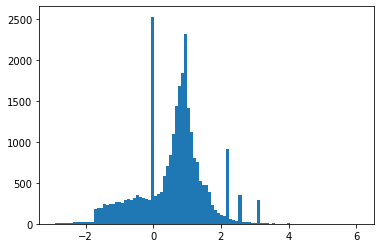

In [12]:
for features, label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(),bins=101)

In [13]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN/BATCH_SIZE

In [14]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [15]:
train_ds

<CacheDataset shapes: ((28,), ()), types: (tf.float32, tf.float32)>

In [16]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

In [17]:
#procedura szkolenia
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps = STEPS_PER_EPOCH*1000,
    decay_rate = 1,
    staircase = False
)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

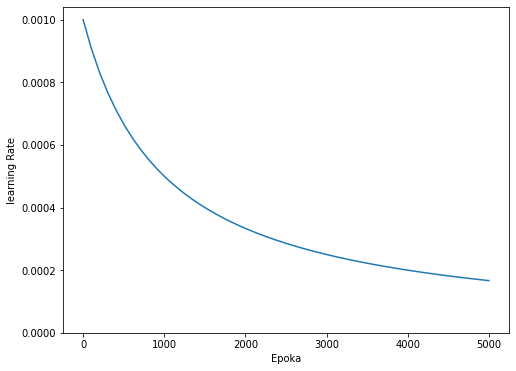

In [18]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize=(8,6))
plt.plot(step/STEPS_PER_EPOCH,lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoka')
_ = plt.ylabel('learning Rate')

In [19]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(monitor='val_binary_crossentropy',patience=200),
        tf.keras.callbacks.TensorBoard(logdir/name)
    ]

In [20]:
def compile_and_fit(model,name,optimizer=None,max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=[
                      tf.keras.losses.BinaryCrossentropy(
                          from_logits=True,name='binary_crossentropy'),
                          'accuracy'
                      
                  ])
    model.summary()
    history = model.fit(
        train_ds,
        steps_per_epoch = STEPS_PER_EPOCH,
        epochs = max_epochs,
        validation_data = validate_ds,
        callbacks = get_callbacks(name),
        verbose = 0
    )
    return history

In [21]:
#bardzo mały model
tiny_model = tf.keras.Sequential([
    layers.Dense(16,activation='elu',input_shape=(FEATURES,)),
    layers.Dense(1)
])

In [22]:
size_histories = {}

In [23]:
size_histories['Tiny'] = compile_and_fit(tiny_model,'sizes/Tiny')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                464       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5142,  binary_crossentropy:0.9225,  loss:0.9225,  val_accuracy:0.4910,  val_binary_crossentropy:0.8028,  val_loss:0.8028,  
....................................................................................................
Epoch: 100, accuracy:0.5838,  binary_crossentropy:0.6354,  loss:0.6354,  val_accuracy:0.5570,  val_binary_crossentropy:0.6374,  val_loss:0.6374,  
............................................................

(0.5, 0.7)

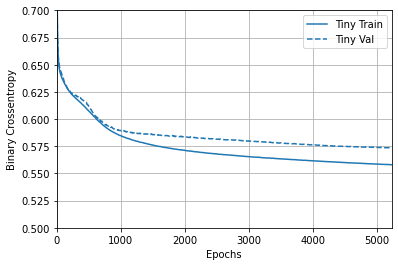

In [24]:
plotter = tfdocs.plots.HistoryPlotter(metric='binary_crossentropy',smoothing_std =10)
plotter.plot(size_histories)
plt.ylim([0.5,0.7])

In [25]:
small_model = tf.keras.Sequential([
    layers.Dense(16,activation='elu',input_shape=(FEATURES,)),
    layers.Dense(16,activation='elu'),
    layers.Dense(1)
])

In [26]:
size_histories['Small'] = compile_and_fit(small_model,'sizes/Small')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 16)                464       
                                                                 
 dense_3 (Dense)             (None, 16)                272       
                                                                 
 dense_4 (Dense)             (None, 1)                 17        
                                                                 
Total params: 753
Trainable params: 753
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4968,  binary_crossentropy:0.7446,  loss:0.7446,  val_accuracy:0.4960,  val_binary_crossentropy:0.7195,  val_loss:0.7195,  
....................................................................................................
Epoch: 100, accuracy:0.6206,  binary_crossentropy:0.6149,  loss:0.6149,  

In [27]:
medium_model = tf.keras.Sequential([
    layers.Dense(64,activation='elu',input_shape=(FEATURES,)),
    layers.Dense(64,activation='elu'),
    layers.Dense(64,activation='elu'),
    layers.Dense(1)
])

In [29]:
size_histories['Medium'] = compile_and_fit(medium_model,'sizes/Medium')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                1856      
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 10,241
Trainable params: 10,241
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.4850,  binary_crossentropy:0.6934,  loss:0.6934,  val_accuracy:0.5020,  val_binary_crossentropy:0.6724,  val_loss:0.6724,  
....................................

In [30]:
large_model = tf.keras.Sequential([
    layers.Dense(512,activation='elu',input_shape=(FEATURES,)),
    layers.Dense(512,activation='elu'),
    layers.Dense(512,activation='elu'),
    layers.Dense(512,activation='elu'),
    layers.Dense(1)
])

In [31]:
size_histories['Large'] = compile_and_fit(large_model,'sizes/Large')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 512)               14848     
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 dense_11 (Dense)            (None, 512)               262656    
                                                                 
 dense_12 (Dense)            (None, 512)               262656    
                                                                 
 dense_13 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5031,  binary_crossentropy

Text(0.5, 0, 'Epoki(skala logarytmiczna)')

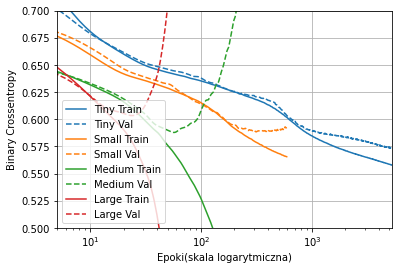

In [34]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5,max(plt.xlim())])
plt.ylim([0.5,0.7])
plt.xlabel("Epoki(skala logarytmiczna)")

In [35]:
shutil.rmtree(logdir/'regularizers/Tiny',ignore_errors=True)
shutil.copytree(logdir/'sizes/Tiny',logdir/'regularizers/Tiny')

PosixPath('/tmp/tmpj7nrk2yr/tensorboard_logs/regularizers/Tiny')

In [36]:
regularizer_history = {}
regularizer_history['Tiny'] = size_histories['Tiny']

Strategie zapobiegania overfit(nadmiernemu dopasowaniu)

1. Regularyzacja wag (L1,L2)
    1. L1 - koszt proporzcjonalny do wsp. wag
    2. L2  - koszt proporcjonalny do kwadratów wartości wsp.wag

In [37]:
l2_model = tf.keras.Sequential([
    layers.Dense(512,activation='elu', kernel_regularizer=regularizers.l2(0.001), input_shape=(FEATURES,)),
    layers.Dense(512,activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512,activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512,activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_history['l2'] = compile_and_fit(l2_model,"regularizers/l2")

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 512)               14848     
                                                                 
 dense_20 (Dense)            (None, 512)               262656    
                                                                 
 dense_21 (Dense)            (None, 512)               262656    
                                                                 
 dense_22 (Dense)            (None, 512)               262656    
                                                                 
 dense_23 (Dense)            (None, 1)                 513       
                                                                 
Total params: 803,329
Trainable params: 803,329
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, accuracy:0.5070,  binary_crossentropy

In [ ]:
plotter.plot(regularizer_history)
plt.ylim([0.5,0.7])

Druga strategia -> rezygnacja (Droput)

In [ ]:
dropout_model = tf.keras.Sequential([
    layers.Dense(512,activation='elu', input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512,activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512,activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512,activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_history['dropout'] = compile_and_fit(droput_model,"regularizers/dropout")

In [ ]:
combined_model = tf.keras.Sequential([
    layers.Dense(512,activation='elu', kernel_regularizer=regularizers.l2(0.001), input_shape=(FEATURES,)),
    layers.Dropout(0.5),
    layers.Dense(512,activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(512,activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(512,activation='elu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_history['combined'] = compile_and_fit(combined_model,"regularizers/combined")